In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from load import get_measures
from load import load_data
from load import train_test_split
from matplotlib import rcParams
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error

rcParams['figure.figsize'] = 15, 5
#plt.style.use('fivethirtyeight') # estilo dos gráficos

In [2]:
# load models forecasts
df = pd.DataFrame()
for file in os.listdir("validation"):
    file_name = "validation/" + file
    df2 = pd.read_csv(file_name, index_col = "date")
    df2.columns = [file[:-7]]
    df = pd.concat([df, df2], axis = 1)

# load "actual" data
n_test = df.shape[0]
test = train_test_split(load_data(), n_test)[1]
test.index = df.index
test.columns = ["test"]

# concatenate forecasts and observed values
df2 = pd.concat([df, test], axis = 1)

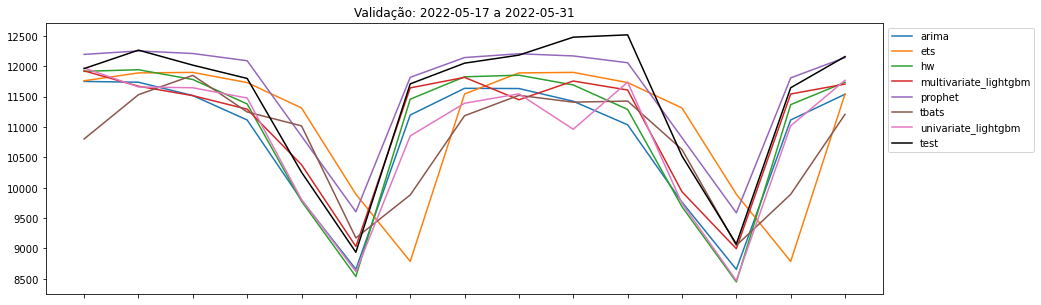

In [3]:
# plot forecasts
for model in df2.columns:
    if model == "test":
        continue
    plt.plot(df2[model], label = model)

# plot observed values
plt.plot(df2["test"], c = "black", label = "test")

# first and last day of the period
date_init = df2.index[0]
date_end = df2.index[-1]
plt.title(f"Validação: {date_init} a {date_end}")

# remove values from X axis
frame1 = plt.gca()  
frame1.axes.xaxis.set_ticklabels([])

# show legend on the right of the plot
plt.legend(bbox_to_anchor = (1,1)) 

plt.show()

In [4]:
# plot using plotly express
df3 = df2.reset_index().melt(id_vars = "date")
px.line(df3, x = "date", y = "value", color= "variable", title=f"Validação: {date_init} a {date_end}")

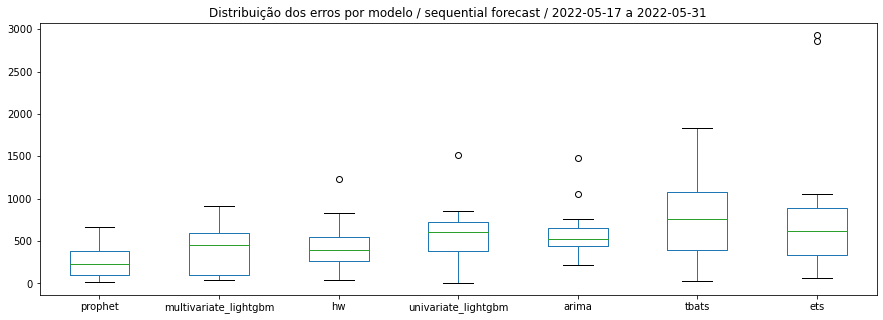

In [5]:
# df de erros por modelo
df_errors = df2.copy(deep=True)
for col in df_errors.columns:
    if col == 'test':
        continue
    else:
        df_errors[col] = df_errors[col] - df_errors['test']
df_errors.drop("test", axis = 1, inplace = True)

sorted_index = df_errors.abs().sum().sort_values().index # ordernar boxplot seguinte por total de erros
#sorted_index = df_errors.quantile(.9).sort_values().index # ordernar boxplot seguinte pelo quantil 95
df_sorted=df_errors[sorted_index].abs()

plt.figure()
df_sorted.boxplot(grid = False)

plt.title(f"Distribuição dos erros por modelo / sequential forecast / {date_init} a {date_end}")

plt.show()
#plt.savefig("distribuicao_erros_modelos_fc.jpeg")

### Medidas de acurácia

In [6]:
dict_metrics = []
for model in df2.columns:
    # skips test column
    if model == "test":
        continue
    # for every model's forecast column
    else:
        # create a dict containing the accuracy measures
        measures = get_measures(df2[model], df2["test"])
        # create a column with the model name
        measures["model"] = model
        # append dictionary to list
        dict_metrics.append(measures)
# create dataframe from list of dicionaries
df2_metrics = pd.DataFrame(dict_metrics)   
# set the last column (model name) as the first one for a better view
temp_cols = df2_metrics.columns.to_list()
new_col_order = temp_cols[-1:] + temp_cols[:-1]
df2_metrics = df2_metrics[new_col_order]

df2_metrics.sort_values(by = "mape")

# write excel file
#df2_metrics.to_excel("performance_df.xlsx", index = False)

,model,erro,mae,mse,rmse,mape,smape,r2
4,prophet,1.681396e+06,265.047726,1.120931e+05,334.803025,0.024960,2.455642,0.913118
3,multivariate_lightgbm,3.408913e+06,383.503509,2.272609e+05,476.718838,0.032385,3.317578,0.823852
2,hw,4.428673e+06,459.395068,2.952449e+05,543.364409,0.040827,4.202007,0.771159
0,arima,6.808620e+06,601.097052,4.539080e+05,673.726936,0.051888,5.357291,0.648180
6,univariate_lightgbm,6.927535e+06,595.940813,4.618356e+05,679.584900,0.051953,5.372194,0.642036
5,tbats,1.373791e+07,798.204358,9.158605e+05,957.006028,0.067702,7.074748,0.290125
1,ets,2.196129e+07,864.065367,1.464086e+06,1209.994142,0.077360,8.131109,-0.134799


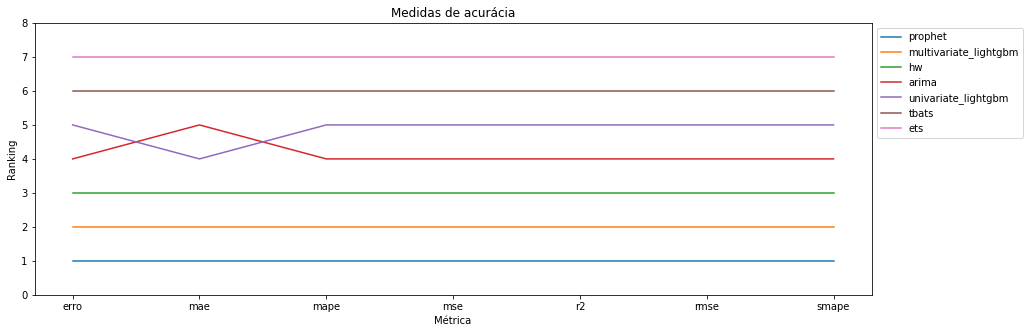

In [7]:
# plot by accuracy measure rank
df2_metrics.loc[:, "r2"] = -df2_metrics.loc[:, "r2"]
df3_metrics = df2_metrics.melt(id_vars = "model", var_name="metric")
df3_metrics["metric_ranking"] = df3_metrics.groupby("metric")["value"].rank("first")
df3_metrics.sort_values(by = ["metric", "metric_ranking"], inplace = True)

plt.figure()

ax = sns.lineplot(data=df3_metrics, x = "metric", y = "metric_ranking", hue="model")
ax.legend(bbox_to_anchor = (1,1))

plt.ylim(0, (df3_metrics["metric_ranking"].max()+1))
plt.ylabel("Ranking")
plt.xlabel("Métrica")
plt.title("Medidas de acurácia")
plt.show()

In [57]:
df2.to_excel("forecasts_observed.xlsx")

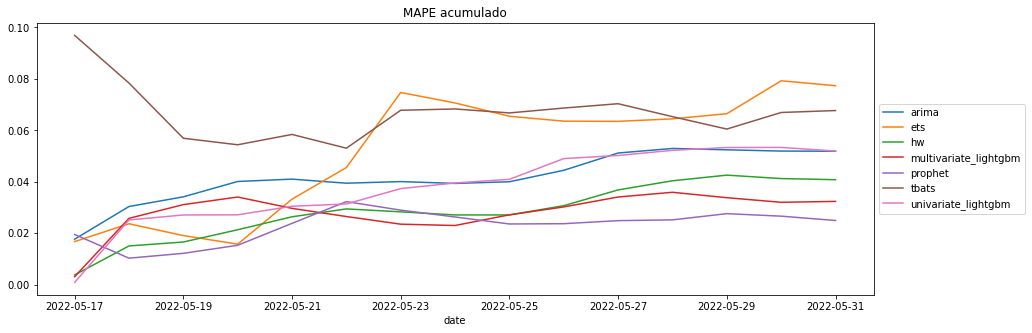

In [63]:
acc_mape_list = []

df2.sort_index(inplace = True) # confirmar ordernação da coluna de data
for col in df2.columns[:-1]: # -1 = coluna "test"
    df_1 = df2.loc[:, [col, "test"]]
    l = []
    for i in range(len(df_1)):
        df_2 = df_1.iloc[:i+1, :]
        acc_mape = mean_absolute_percentage_error(df_2.iloc[:,1], df_2.iloc[:,0])  # test, pred
        l.append(acc_mape)
    l2 = pd.Series(l)
    acc_mape_list.append(l2)
df_acc_mape = pd.concat(acc_mape_list, axis = 1)       
df_acc_mape.columns = df2.columns[:-1]
df_acc_mape.index = test.index
df_acc_mape.plot(title = "MAPE acumulado")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

### Ensemble

In [8]:
# Create combination of every columns
import itertools
df_ensemble = df2.drop("test", axis = 1) # remove test column
ensemble_list = [x for x in df_ensemble.columns] # create a list with the name of every column
combs = []
for r in range(2, len(df_ensemble.columns)+1):
    for comb in itertools.combinations(ensemble_list,r): # r: number of items in the tuple (from 1 to n-columns)
        combs.append(list(comb))

# Create a dictionary with the combinations
ensemble_dict = {}
for comb in combs:
    df_ensemble_subset =  df_ensemble[comb] # select the combination of columns
    df_ensemble_cols = '-'.join(comb) # create string with the names of the columns joined by '-'
    df_ensembled = df_ensemble_subset.mean(axis = 1) # calculate the average of the forecasts at time T
    ensemble_dict[df_ensemble_cols] = df_ensembled # add result to dictionary

# Create a dataframe with the MAPE of each ensemble
ensemble_measures = []
for ensemble, series in ensemble_dict.items(): # tuple with the name of the key and the content
    measure = get_measures(ensemble_dict[ensemble], df2["test"])["mape"] # MAPE 
    new_line = {"ensemble": ensemble, "mape": measure} # ensemble: name; measure: MAPE
    ensemble_measures.append(new_line)
df_ensemble_results =  pd.DataFrame(ensemble_measures).sort_values(by = "mape") # transform list of dictionaries into a DataFrame and order by MAPE
best_ensemble = df_ensemble_results.iloc[0,0] # select the model with smaller MAPE
best_ensemble_series = ensemble_dict[best_ensemble]

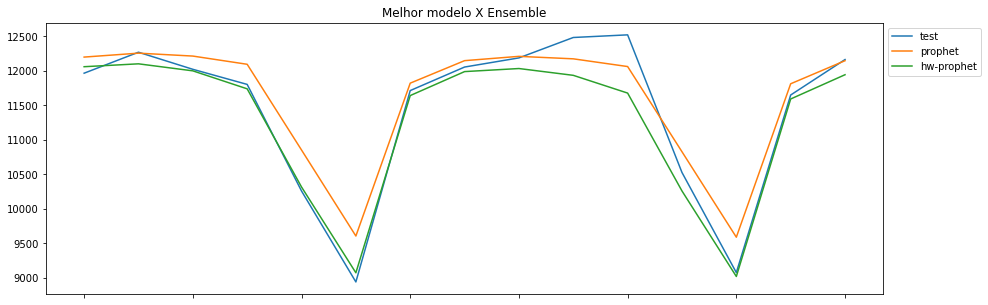

In [9]:
# Plot best single model vs best ensemble
plt.plot(df2["test"], label = "test")

best_model = df2_metrics.sort_values(by="mape").reset_index().loc[0,"model"] # critério: MAPE
plt.plot(df2[best_model], label = best_model)

best_ensemble_series.index = df2["test"].index
plt.plot(best_ensemble_series, label = best_ensemble)

plt.title("Melhor modelo X Ensemble")
plt.legend(bbox_to_anchor = (1,1)) # legenda na lateral direita
frame1 = plt.gca()  # retirar valores do eixo x
frame1.axes.xaxis.set_ticklabels([])

plt.show()

In [10]:
print("MAPE modelo: ", df2_metrics.sort_values(by="mape").reset_index().loc[0,"mape"])
print("MAPE ensemble: ", df_ensemble_results.iloc[0,1])

MAPE modelo:  0.02496
MAPE ensemble:  0.015986
